# Comparison of two-canyon runs

* All experiments have 3 runs to get a mean curve (except aug01, I eliminated run that does weird things).
* Parameters can be found on google drive sheet lab_speadsheets/exp_list

Using calibration from July 6th (closest calibration when all probes were connected) and also the one on the 9th Aug (closest to exeriments) to check how it affects density change in the canyon heads.


In [1]:
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.polynomial import polynomial as P
import os
import pandas as pd
#import seaborn as sns
import scipy.io as sio
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('/ocean/kramosmu/MultipleCanyons/lab/Conduino/scripts')
import profiler_tools as ptools
import conduino_tools as ctools


In [2]:
sns.set_style('whitegrid')
sns.set_context('notebook')

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [4]:
def plot_uprofile(ax, col='0.8'):
    ax.axvline(21.0, color=col, linestyle=':')
    ax.axvline(71.0, color=col, linestyle=':')
        
def plot_forcing(ax, file, f0, f1, f2, t0, t1):
    '''ax: axes to plot figure on
       file: experiment file to extract time
       f0: Angular velocity of the table during spin up
       f1: f at max forcing
       f2: f to avoid spin down
       t0: time to get to f1
       t1: time to get to f2'''
    mat = sio.loadmat(file, squeeze_me=True)
    time = mat['time']
    t2 = np.round(np.max(time),2) # s

    ax0.text(0.3,0.3,r'$\Delta f_1=$%1.2f rad/s, $\Delta t_1=$%1.1f s' %((f1-f0),t0), transform=ax0.transAxes)
    ax0.text(0.5,0.7,r'$\Delta f_2=$%1.2f rad/s, $\Delta t_2=$%1.1f s' %((f2-f1),(t1-t0)), transform=ax0.transAxes)

    ax0.plot([0,t0,t1,t2],[f0,f1,f2,f2], 'g-')
    ax0.set_ylabel('f table / rad s$^{-1}$')
    ax0.set_xlabel('time / s')

In [29]:
# Dictionaries:

A01 = {"date": "31Jul19",
       "Nsb": 1.23 ,
       "Nshelf": 1.5,
       "fo": 0.5 ,
       "U":0.5 ,
       "run_num": 3,''
       "dir": '../experiments/exp_31jul19/',
       "run_files":['06_experiment1.mat','09_experiment2.mat','12_experiment3.mat'],
       "color":'mediumseagreen',
       "rho_top":[1.01706,1.01775,1.0782],
       "rho_sb":[1.02405,1.02349,1.02401],
       "rho_bot":[1.03744,1.03791,1.03715],
       "hsb":2.9,
       "hbot":9.5,
       }
A02 = {"date": "01Aug19",
       "Nsb": 1.03 ,
       "Nshelf": 1.02,
       "fo": 0.5 ,
       "U":0.5 ,
       "run_num": 2,''
       "dir": '../experiments/exp_01aug19/',
       "run_files":['06_experiment1.mat','09_experiment2.mat','13_experiment3.mat'],
       "color":'darkcyan',
       "rho_top":[1.01167,1.01238,1.01240],
       "rho_sb":[1.01470,1.01553,1.01542],
       "rho_bot":[1.02617,1.02569,1.02610],
       "hsb":2.9,
       "hbot":9.5,
       }
A03 = {"date": "05Aug19",
       "Nsb": 0.92 ,
       "Nshelf": 1.2,
       "fo": 0.5 ,
       "U":0.5 ,
       "run_num": 3,''
       "dir": '../experiments/exp_05aug19/',
       "run_files":['05_experiment1.mat','07_experiment2.mat','09_experiment3.mat'],
       "color":'darkslateblue',
       "rho_top":[1.00764,1.00828,np.nan],
       "rho_sb":[1.01184,1.01273,np.nan],
       "rho_bot":[1.01819,1.01842,np.nan],
       "hsb":2.85,
       "hbot":9.45,
       }

A04 = {"date": "07Aug19",
       "Nsb": 1.46 ,
       "Nshelf": 1.47,
       "fo": 0.5 ,
       "U":0.5 ,
       "run_num": 4,
       "dir": '../experiments/exp_07aug19/',
       "run_files":['04_experiment1.mat','07_experiment2.mat','09_experiment3.mat', '10_experiment4.mat'],
       "color":'darkmagenta',
       "rho_top":[1.00977,1.00967,1.01110,np.nan],
       "rho_sb":[1.01612,1.01680,1.01617,np.nan],
       "rho_bot":[1.02616,1.02611,1.02593,np.nan],
       "hsb":2.9,
       "hbot":9.5,
       }

A05 = {"date": "08Aug19",
       "Nsb": 1.46 ,
       "Nshelf": 1.45,
       "fo": 0.5 ,
       "U":0.5 ,
       "run_num": 3,
       "dir": '../experiments/exp_08aug19/',
       "run_files":['04_experiment1.mat','09_experiment3.mat'],#,'07_experiment2.mat'],
       "color":'plum',
       "rho_top":[1.01740,1.01781,np.nan],
       "rho_sb":[1.02351,1.02408,np.nan],
       "rho_bot":[1.03658,1.03651,np.nan],
       "hsb":2.9,
       "hbot":9.5,
       }
A06 = {"date": "10Aug19",
       "Nsb": 1.81 ,
       "Nshelf": 1.81,
       "fo": 0.8 ,
       "U":0.5 ,
       "run_num": 3,
       "dir": '../experiments/exp_10aug19/',
       "run_files":['06_experiment1.mat','08_experiment2.mat'],#,'11_experiment3.mat'],
       "color":'coral',
       "rho_top":[1.01580,1.01575,1.01607],
       "rho_sb":[1.02557,1.02362,1.02415],
       "rho_bot":[1.04029,1.04106,1.04006],
       "hsb":2.85,
       "hbot":9.45,
       }


In [30]:
exp_dicts = [A01,A02,A03,A04,A05,A06]
exp_num = len(exp_dicts) # number of experiment dictionaries

colors = ['teal','darkorange','yellowgreen', 'tan']
exp_Norder = [A02,A03,A05,A04,A01,A06]

### READINGS

../experiments/exp_31jul19/06_experiment1.mat
../experiments/exp_31jul19/09_experiment2.mat
../experiments/exp_31jul19/12_experiment3.mat
../experiments/exp_01aug19/06_experiment1.mat
../experiments/exp_01aug19/09_experiment2.mat
../experiments/exp_01aug19/13_experiment3.mat
../experiments/exp_05aug19/05_experiment1.mat
../experiments/exp_05aug19/07_experiment2.mat
../experiments/exp_05aug19/09_experiment3.mat
../experiments/exp_07aug19/04_experiment1.mat
../experiments/exp_07aug19/07_experiment2.mat
../experiments/exp_07aug19/09_experiment3.mat
../experiments/exp_07aug19/10_experiment4.mat
../experiments/exp_08aug19/04_experiment1.mat
../experiments/exp_08aug19/09_experiment3.mat
../experiments/exp_10aug19/06_experiment1.mat
../experiments/exp_10aug19/08_experiment2.mat


Text(0.5,0,'time / s')

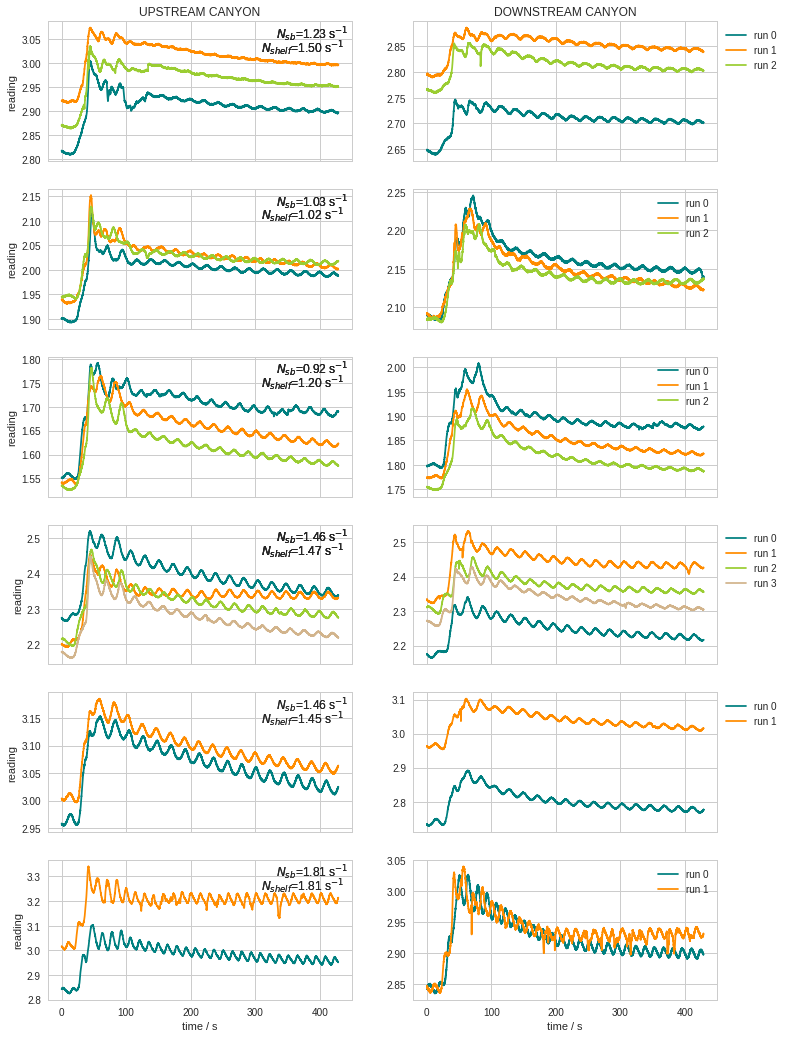

In [31]:
fig, ax = plt.subplots(exp_num, 2, figsize=(12,exp_num*3), sharex=True)

ax[0,0].set_title('UPSTREAM CANYON')
ax[0,1].set_title('DOWNSTREAM CANYON')

for exp, kk in zip(exp_dicts, range(exp_num)):
    
    for ii, col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        print(filepath)
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        time = mat['time']
        ax[kk,0].plot(time,P1,'-',color=col, label='run %d' %ii)
        ax[kk,1].plot(time,P2,'-',color=col, label='run %d' %ii)
        ax[kk,0].text(0.75,0.88,'$N_{sb}$=%1.2f s$^{-1}$' %exp["Nsb"], transform=ax[kk,0].transAxes)
        ax[kk,0].text(0.7,0.78,'$N_{shelf}$=%1.2f s$^{-1}$' %exp["Nshelf"], transform=ax[kk,0].transAxes)
       
    ax[kk,0].set_ylabel('reading')
    ax[kk,1].legend(bbox_to_anchor=(1,1))

ax[kk,0].set_xlabel('time / s')
ax[kk,1].set_xlabel('time / s')


### Density change from initial value

Using calibration July 6th:

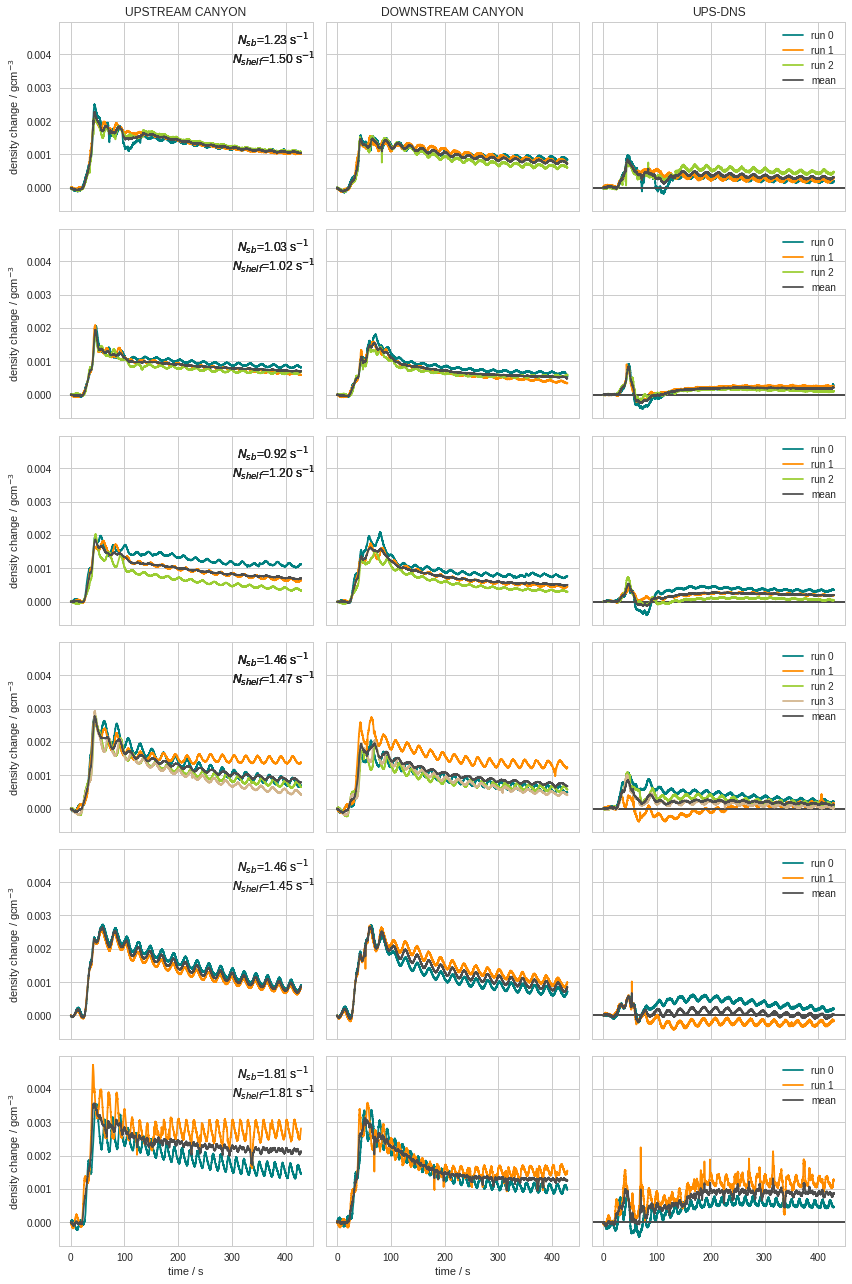

In [32]:
fig, ax = plt.subplots(exp_num, 3, figsize=(12,exp_num*3), sharey=True, sharex=True)

ax[0,0].set_title('UPSTREAM CANYON')
ax[0,1].set_title('DOWNSTREAM CANYON')
ax[0,2].set_title('UPS-DNS')

for exp, kk in zip(exp_dicts, range(exp_num)):
    avg1 = np.zeros_like(time)
    avg2 = np.zeros_like(time)
    avg3 = np.zeros_like(time)
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        time = mat['time']
        dens1 = ctools.densANK1_06Jul19(P1)
        dens2 = ctools.densANK2_06Jul19(P2)
        ax[kk,0].plot(time, dens1-dens1[0],'-',color=col, label='run %d' %ii)
        ax[kk,1].plot(time, dens2-dens2[0],'-',color=col, label='run %d' %ii)
        ax[kk,2].axhline(0, color='0.3')
        ax[kk,2].plot(time, (dens1-dens1[0])-(dens2-dens2[0]),'-',color=col, label='run %d' %ii)
        ax[kk,0].text(0.70,0.88,'$N_{sb}$=%1.2f s$^{-1}$' %exp["Nsb"], transform=ax[kk,0].transAxes)
        ax[kk,0].text(0.68,0.78,'$N_{shelf}$=%1.2f s$^{-1}$' %exp["Nshelf"], transform=ax[kk,0].transAxes)
        avg1 = avg1+(dens1-dens1[0])
        avg2 = avg2+(dens2-dens2[0])
        avg3 = avg3+((dens1-dens1[0])-(dens2-dens2[0]))
    ax[kk,0].plot(time, avg1/(len(exp['run_files'])),'-',color='0.3', label='mean')
    ax[kk,1].plot(time, avg2/(len(exp['run_files'])),'-',color='0.3', label='mean')
    ax[kk,2].plot(time, avg3/(len(exp['run_files'])),'-',color='0.3', label='mean')    
    ax[kk,0].set_ylabel('density change / gcm$^{-3}$')
    ax[kk,2].legend(bbox_to_anchor=(1,1))

ax[kk,0].set_xlabel('time / s')
ax[kk,1].set_xlabel('time / s')
plt.tight_layout()

Using calibration Aug 9th - Density in both probes is a bit larger using July 6th calibration

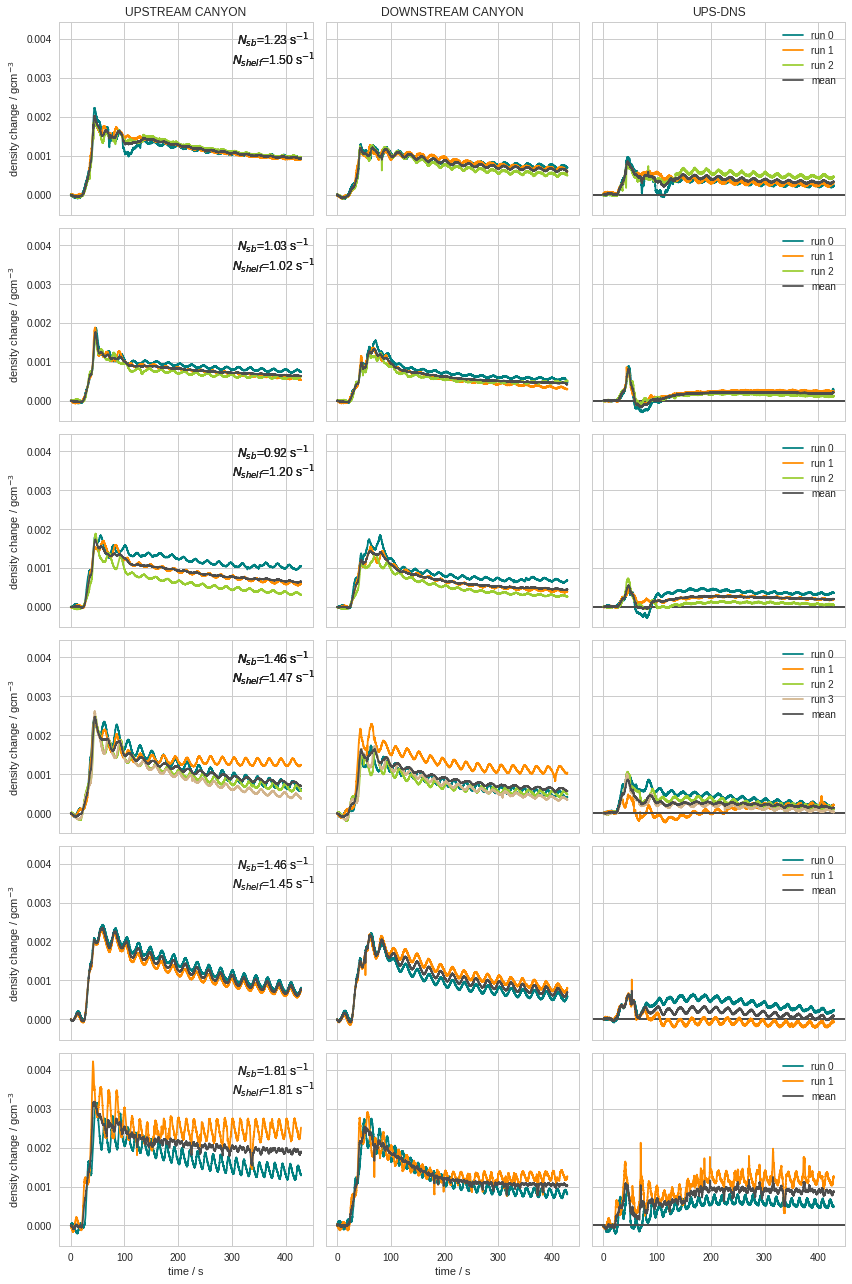

In [33]:
fig, ax = plt.subplots(exp_num, 3, figsize=(12,exp_num*3), sharey=True, sharex=True)

ax[0,0].set_title('UPSTREAM CANYON')
ax[0,1].set_title('DOWNSTREAM CANYON')
ax[0,2].set_title('UPS-DNS')

for exp, kk in zip(exp_dicts, range(exp_num)):
    avg1 = np.zeros_like(time)
    avg2 = np.zeros_like(time)
    avg3 = np.zeros_like(time)
    
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        time = mat['time']
        dens1 = ctools.densANK1_09Aug19(P1)
        dens2 = ctools.densANK2_09Aug19(P2)
        ax[kk,0].plot(time, dens1-dens1[0],'-',color=col, label='run %d' %ii)
        ax[kk,1].plot(time, dens2-dens2[0],'-',color=col, label='run %d' %ii)
        ax[kk,2].axhline(0, color='0.3')
        ax[kk,2].plot(time, (dens1-dens1[0])-(dens2-dens2[0]),'-',color=col, label='run %d' %ii)
        ax[kk,0].text(0.70,0.88,'$N_{sb}$=%1.2f s$^{-1}$' %exp["Nsb"], transform=ax[kk,0].transAxes)
        ax[kk,0].text(0.68,0.78,'$N_{shelf}$=%1.2f s$^{-1}$' %exp["Nshelf"], transform=ax[kk,0].transAxes)
        avg1 = avg1+(dens1-dens1[0])
        avg2 = avg2+(dens2-dens2[0])
        avg3 = avg3+((dens1-dens1[0])-(dens2-dens2[0]))
    
    ax[kk,0].plot(time, avg1/(len(exp['run_files'])),'-',color='0.3', label='mean')
    ax[kk,1].plot(time, avg2/(len(exp['run_files'])),'-',color='0.3', label='mean')
    ax[kk,2].plot(time, avg3/(len(exp['run_files'])),'-',color='0.3', label='mean')    
    ax[kk,0].set_ylabel('density change / gcm$^{-3}$')
    ax[kk,2].legend(bbox_to_anchor=(1,1))

ax[kk,0].set_xlabel('time / s')
ax[kk,1].set_xlabel('time / s')
plt.tight_layout()

### Comparison average runs

Using calibration July 6th

Text(0.5,0,'time / s')

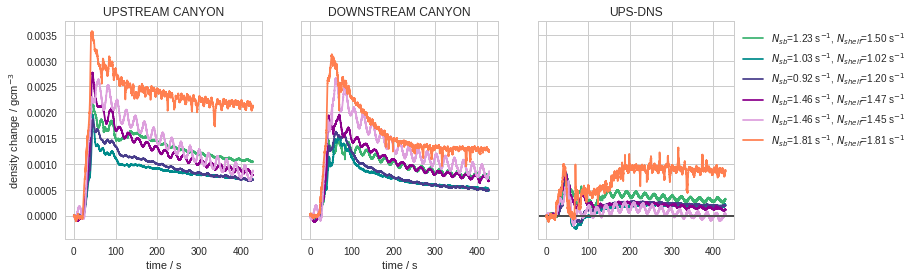

In [34]:
fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True, sharex=True)

ax[0].set_title('UPSTREAM CANYON')
ax[1].set_title('DOWNSTREAM CANYON')
ax[2].set_title('UPS-DNS')

for exp, kk in zip(exp_dicts, range(exp_num)):
    avg1 = np.zeros_like(time)
    avg2 = np.zeros_like(time)
    avg3 = np.zeros_like(time)
    
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        time = mat['time']
        dens1 = ctools.densANK1_06Jul19(P1)
        dens2 = ctools.densANK2_06Jul19(P2)
        ax[2].axhline(0, color='0.3')
        label = '$N_{sb}$=%1.2f s$^{-1}$, $N_{shelf}$=%1.2f s$^{-1}$' %(exp["Nsb"],exp["Nshelf"])
        avg1 = avg1+(dens1-dens1[0])
        avg2 = avg2+(dens2-dens2[0])
        avg3 = avg3+((dens1-dens1[0])-(dens2-dens2[0]))
    
    ax[0].plot(time, avg1/(len(exp['run_files'])),'-',color=exp['color'], label=label)
    ax[1].plot(time, avg2/(len(exp['run_files'])),'-',color=exp["color"], label=label)
    ax[2].plot(time, avg3/(len(exp['run_files'])),'-',color=exp["color"], label=label)    
    ax[0].set_ylabel('density change / gcm$^{-3}$')
    ax[2].legend(bbox_to_anchor=(1,1))

ax[0].set_xlabel('time / s')
ax[1].set_xlabel('time / s')
#plt.tight_layout()

Using calibration Aug 9th

Text(0.5,0,'time / s')

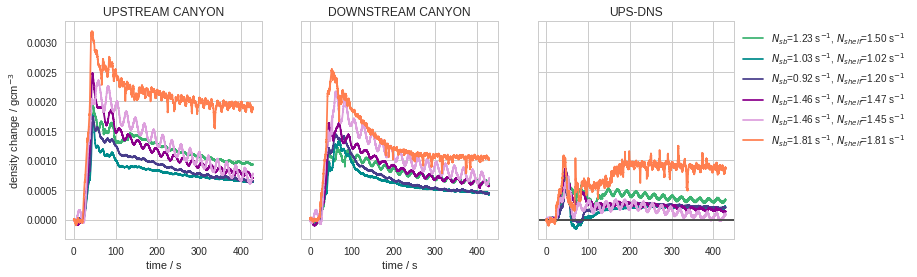

In [35]:
fig, ax = plt.subplots(1, 3, figsize=(12,4), sharey=True, sharex=True)

ax[0].set_title('UPSTREAM CANYON')
ax[1].set_title('DOWNSTREAM CANYON')
ax[2].set_title('UPS-DNS')

for exp, kk in zip(exp_dicts, range(exp_num)):
    avg1 = np.zeros_like(time)
    avg2 = np.zeros_like(time)
    avg3 = np.zeros_like(time)
    
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        time = mat['time']
        dens1 = ctools.densANK1_09Aug19(P1)
        dens2 = ctools.densANK2_09Aug19(P2)
        ax[2].axhline(0, color='0.3')
        label = '$N_{sb}$=%1.2f s$^{-1}$, $N_{shelf}$=%1.2f s$^{-1}$' %(exp["Nsb"],exp["Nshelf"])
        avg1 = avg1+(dens1-dens1[0])
        avg2 = avg2+(dens2-dens2[0])
        avg3 = avg3+((dens1-dens1[0])-(dens2-dens2[0]))
    
    ax[0].plot(time, avg1/(len(exp['run_files'])),'-',color=exp['color'], label=label)
    ax[1].plot(time, avg2/(len(exp['run_files'])),'-',color=exp["color"], label=label)
    ax[2].plot(time, avg3/(len(exp['run_files'])),'-',color=exp["color"], label=label)    
    ax[0].set_ylabel('density change / gcm$^{-3}$')
    ax[2].legend(bbox_to_anchor=(1,1))

ax[0].set_xlabel('time / s')
ax[1].set_xlabel('time / s')


### Plots arranged by $N_{shelf}$ and $f$

Plotting mean upstream, mean downstream and mean difference filtered using salish sea filter_timeseries with window win = int(T/dt) where T is the inertial period and dt the time between conduino samples.  

In [36]:
def filter_timeseries(record, winlen=39):
    
    '''as in filter_timesies in salish sea tidetools.py without doodson option'''
    
    filtered = record.copy()
    record_length = record.shape[0]
    w = (winlen - 1) // 2
    weight = np.zeros(w, dtype=int)
    weight[:] = 1
    centerval = 1
    
    #Loop through record
    for i in range(record_length):
        
        # Adjust window length for end cases
        W = min(i, w, record_length-i-1)
        Weight = weight[:W]
        Weight = np.append(Weight[::-1], np.append(centerval, Weight))
        if sum(Weight) != 0:
            Weight = (Weight/sum(Weight))
        
        # Expand weight dims so it can operate on record window
        for dim in range(record.ndim - 1):
            Weight = Weight[:, np.newaxis]
        
        # Apply mean over window length
        if W > 0:
            filtered[i, ...] = np.sum(record[i-W:i+W+1, ...] * Weight, axis=0)
        else:
            filtered[i, ...] = record[i, ...]
    
    return filtered


12.566370614359172
12.566370614359172
12.566370614359172
12.566370614359172
12.566370614359172
7.853981633974483


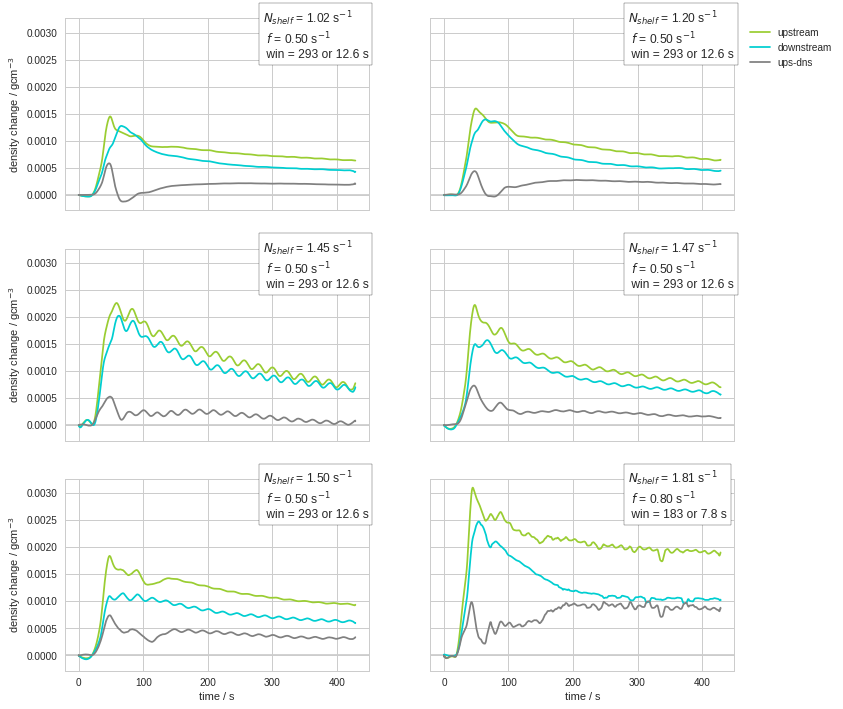

In [37]:
fig, ((ax0,ax1),(ax2,ax3),(ax4,ax5)) = plt.subplots(3, 2, figsize=(12,12), sharey=True, sharex=True)

axs = [ax0,ax1,ax2,ax3,ax4,ax5]

for exp, kk, ax in zip(exp_Norder, range(exp_num), axs):
    avg1 = np.zeros_like(time)
    avg2 = np.zeros_like(time)
    avg3 = np.zeros_like(time)
    
    for ii,col in zip(range(len(exp['run_files'])),colors):
        filepath = exp['dir']+exp['run_files'][ii]
        mat = sio.loadmat(filepath, squeeze_me=True)
        P1 = mat['ch1']
        P2 = mat['ch2']
        dt = mat['dt']
        time = mat['time']
        dens1 = ctools.densANK1_09Aug19(P1)
        dens2 = ctools.densANK2_09Aug19(P2)
        avg1 = avg1+(dens1-dens1[0])
        avg2 = avg2+(dens2-dens2[0])
        avg3 = avg3+((dens1-dens1[0])-(dens2-dens2[0]))
     
    inertial_period = 1/((exp["fo"])/(2*np.pi))
    win = int(inertial_period/dt)
    print(inertial_period)
    ax.axhline(0, color='0.8')
    ax.text(0.65,0.8,'$N_{shelf}$ = %1.2f s$^{-1}$ \n $f$ = %1.2f s$^{-1}$ \n win = %d or %1.1f s' \
            %(exp["Nshelf"],exp["fo"],win, win*dt), transform=ax.transAxes,
            bbox=dict(facecolor='white', alpha=1) )
    
    ax.plot(time, filter_timeseries(avg1/(len(exp['run_files'])),winlen=win),'-',
            color='yellowgreen', label='upstream')
    ax.plot(time, filter_timeseries(avg2/(len(exp['run_files'])),winlen=win),'-',
            color='darkturquoise', label='downstream')
    ax.plot(time, filter_timeseries(avg3/(len(exp['run_files'])),winlen=win),
            '-',color='0.5', label='ups-dns')    
    

for ax in [ax0,ax2,ax4]:
    ax.set_ylabel('density change / gcm$^{-3}$')
ax4.set_xlabel('time / s')
ax5.set_xlabel('time / s')
ax1.legend(bbox_to_anchor=(1.35,1))